In [1]:
import os
import numpy as np
import math as m
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda
import matplotlib.pyplot as plt

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
from numba import int64, float64, int16, float32

@vectorize([float64(int64)], target='parallel', fastmath=True)
def v_exp(arg):
    return np.exp(arg)

@vectorize([float64(int64)])
def v_log(arg):
    return np.log(arg)

A = np.array([2,5,10,3,8], dtype=np.int64)

print("A:", A)
print("log:", v_log(A))
print("exp:", v_exp(A))

A: [ 2  5 10  3  8]
log: [0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
exp: [7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

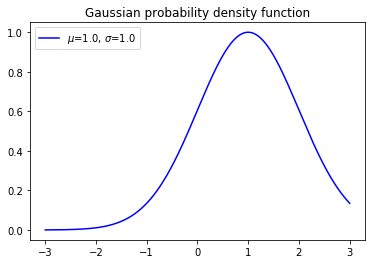

In [3]:
@vectorize([float64(float64, float64, float64)], target='parallel', fastmath=True)
def gauss(x, mean, sigma):
    return np.exp(-0.5*np.power((float(x)-float(mean))/sigma, 2.))
        
mean, sigma = 1., 1.
x = np.linspace(-3,3,100000)

plt.plot(x, gauss(x, mean, sigma), 'b',label="$\mu$=1.0, $\sigma$=1.0")
plt.title("Gaussian probability density function")
plt.legend(loc='best')
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

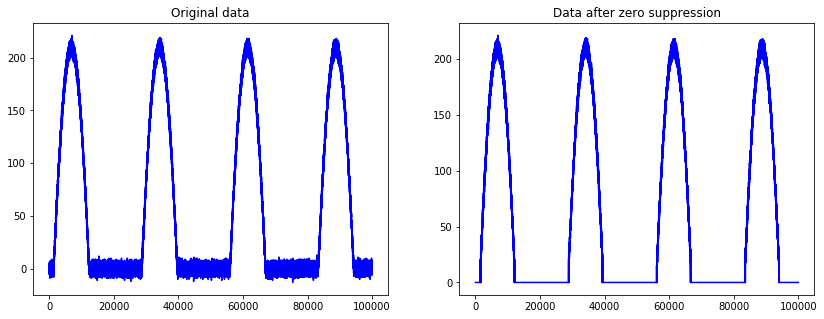

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax1.plot(data, 'b')
ax1.set_title('Original data')

threshold = 15

@vectorize([int16(int16, int16)], target='parallel', fastmath=True)
def zero_suppress(X, threshold):
    if X < threshold:
        X = 0
    return X
        
ax2.plot(zero_suppress(data, threshold), 'b')
ax2.set_title('Data after zero suppression')
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

#definition of the function
@jit([float32[:,:](float32[:,:],float32[:,:],float32,float32)])
def sigmoid_kernel(X,Y,alpha,c):
    transposeX = np.transpose(X)
    return np.tanh(alpha*transposeX*Y+c)

#casting properly
X = X.astype(np.float32)
Y = Y.astype(np.float32)
#parameters
alpha=2.
c=1.
#running the function
K=sigmoid_kernel(X,Y,alpha,c)
print(K)

[[0.9031555  0.8387953  0.92439795]
 [0.97981644 0.76724285 0.7884092 ]
 [0.97454923 0.7888082  0.96935   ]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

I didn't manage to compute the result in a resonable time, so just for the purpose of showing that the code is working I show instead the result for a 24x24x24 matrix. Nothing suggests that with more computational resources the result for the full matrix couldn't be computed using this code.

In [6]:
from __future__ import division

#definitin of the kernel
@cuda.jit
def double_kernel(io_array, out_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        out_array[x,y,z] = m.cos(io_array[x,y,z])
        
        
# Creating the data array
#data = (np.random.rand(256,256,256)*4*m.pi-2*m.pi).astype(np.float32)
data = (np.random.rand(24,24,24)*4*m.pi-2*m.pi).astype(np.float32)

#setting proper variables for the kernel
threadsperblock = (8, 8, 4)
blockspergrid_x = int(m.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(m.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

#empty output array to feed the kernel
#C = np.zeros((256,256,256))
C=np.zeros((24,24,24))

# Running the kernel
double_kernel[blockspergrid, threadsperblock](data, C)

print(C)

[[[ 0.93730931 -0.0175042   0.28551198 ... -0.83738404 -0.15962031
    0.16792844]
  [ 0.87575184  0.83491035  0.87331089 ...  0.90551878 -0.75174634
   -0.9997268 ]
  [ 0.9134394  -0.4111662   0.99978586 ...  0.72466579 -0.95509661
   -0.95396632]
  ...
  [ 0.97091391 -0.95132192  0.27466626 ...  0.92155436  0.10619132
   -0.61808745]
  [ 0.99943913  0.5284019   0.75390805 ...  0.73345242  0.85262494
    0.75257674]
  [ 0.96944942 -0.58872864 -0.93351901 ... -0.11256004  0.04374165
    0.78646925]]

 [[-0.82418883  0.49566372  0.94929626 ... -0.54952741  0.53632614
    0.54478742]
  [ 0.64508805  0.53338916 -0.96611106 ...  0.54996374  0.14729105
    0.98555503]
  [-0.78091096 -0.17378478  0.06617304 ...  0.76152063 -0.97702418
   -0.80541857]
  ...
  [-0.36607201  0.99717277 -0.42130801 ... -0.34740196 -0.55269902
   -0.49123817]
  [ 0.41676663 -0.07954367 -0.35876528 ...  0.15531213 -0.53833567
    0.68981973]
  [-0.97561466 -0.85548088  0.49953388 ...  0.2811262  -0.96083822
   -0.

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x22$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(10, size=(24,12))
B = np.random.randint(10, size=(12,22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (3,2)
blockspergrid_x = int(m.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)

print(C)

[[229. 234. 266. 262. 340. 284. 326. 319. 303. 413. 160. 190. 251. 282.
  339. 295. 224. 203. 400. 244. 297. 184.]
 [292. 341. 356. 216. 407. 389. 422. 358. 344. 451. 222. 292. 206. 359.
  460. 328. 258. 265. 434. 267. 292. 332.]
 [256. 236. 283. 195. 279. 234. 320. 252. 257. 313. 172. 226. 200. 280.
  332. 259. 222. 190. 348. 222. 258. 214.]
 [236. 225. 207. 224. 288. 267. 327. 326. 257. 339. 149. 233. 176. 258.
  354. 309. 237. 185. 372. 223. 172. 234.]
 [239. 230. 293. 191. 316. 265. 376. 315. 271. 403. 202. 240. 240. 304.
  319. 239. 281. 215. 384. 202. 313. 240.]
 [257. 213. 258. 275. 323. 235. 343. 314. 309. 402. 175. 221. 254. 285.
  345. 297. 257. 177. 418. 247. 301. 187.]
 [215. 155. 196. 186. 245. 198. 258. 258. 265. 333. 183. 177. 169. 202.
  302. 215. 249.  89. 321. 179. 197. 213.]
 [169. 155. 205. 119. 215. 151. 256. 177. 182. 226. 154. 217. 114. 170.
  251. 173. 195.  86. 237. 112. 173. 195.]
 [159. 200. 204.  96. 275. 253. 296. 218. 179. 266. 134. 197. 123. 211.
  263. 2